# Coursework 2: Generative Models

## Instructions

### Submission
Please submit one zip file on cate - *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question. **Please deliver the notebook including the outputs of the cells**
2. Your trained VAE model as *VAE_model.pth*
3. Your trained Generator and Discriminator: *DCGAN_model_D.pth and DCGAN_model_G.pth*


### Training
Training the GAN will take quite a long time (multiple hours), and so you have four options:
1. Use PaperSpace [as suggested for CW1](https://hackmd.io/@afspies/S1stL8Qnt)
2. Use Lab GPUs via SSH.  The VSCode Remote Develop extension is recommended for this. For general Imperial remote working instructions see [this post](https://www.doc.ic.ac.uk/~nuric/teaching/remote-working-for-imperial-computing-students.html). You'll also want to [setup your environment as outlined here](https://hackmd.io/@afspies/Bkd7Zq60K).
3. Use Colab and add checkpointing to the model training code; this is to handle the case where colab stops a free-GPU kernel after a certain number of hours (~4).
4. Use Colab Pro - If you do not wish to use PaperSpace then you can pay for Colab Pro. We cannot pay for this on your behalf (this is Google's fault).


### Testing
TAs will run a testing cell (at the end of this notebook), so you are required to copy your data ```transform``` and ```denorm``` functions to a cell near the bottom of the document (it is demarkated). You are advised to check that your implementations pass these tests (in particular, the jit saving and loading may not work for certain niche functions)

### General
You can feel free to add architectural alterations / custom functions outside of pre-defined code blocks, but if you manipulate the model's inputs in some way, please include the same code in the TA test cell, so our tests will run easily.

<font color="orange">**The deadline for submission is 19:00, Friday 24th February, 2022** </font>

## Setting up working environment
You will need to install pytorch and import some utilities by running the following cell:

In [1]:
!pip install -q torch torchvision altair seaborn
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
from pathlib import Path
import tqdm

fatal: destination path 'icl_dl_cw2_utils' already exists and is not an empty directory.


Here we have some default pathing options which vary depending on the environment you are using. You can of course change these as you please.

In [2]:
WORKING_ENV = 'PAPERSPACE' # Can be LABS, COLAB or PAPERSPACE
USERNAME = 'hgc19' # If working on Lab Machines - Your college username
assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE']

if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    content_path = '/content/drive/MyDrive/dl_cw_2'
    data_path = './data/'
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

elif WORKING_ENV == 'LABS':
    content_path = '~/Documents/dl_cw_2' # You may want to change this
    # Your python env and training data should be on bitbucket
    data_path = f'/vol/bitbucket/{USERNAME}/dl_cw_data/'

else: # Using Paperspace
    # Paperspace does not properly render animated progress bars
    # Strongly recommend using the JupyterLab UI instead of theirs
    !pip install ipywidgets 
    content_path = '/notebooks'
    data_path = './data/'

content_path = Path(content_path)

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

Each part is worth 50 points. 

The emphasis of both parts lies in understanding how the models behave and learn, however, some points will be available for getting good results with your GAN (though you should not spend too long on this).

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture with accompanying hyperparameters. More marks are awarded for using a Convolutional Encoder and Decoder.

b. Design an appropriate loss function and train the model.


In [3]:
import os
import numpy as np
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_VAE/'):
    os.makedirs(content_path/'CW_VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


---
## Part 1.1a: Implement VAE (25 Points)
### Hyper-parameter selection


In [4]:
# Necessary Hyperparameters 
num_epochs = 20
learning_rate = 5E-4
batch_size = 256
latent_dim = 12 # Choose a value for the size of the latent space

# Additional Hyperparameters 


# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

### Data loading


In [5]:
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change 
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path/'CW_VAE/image_original.png')

### Model Definition



You will need to define:
* The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward



Hints:
- It is common practice to encode the log of the variance, rather than the variance
- You might try using BatchNorm

In [6]:
class VAE(nn.Module):
    def __init__(self,
                 latent_dims,
                 in_channels=1):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        self.latent_dims = latent_dims
        hidden_dims = [24, 24, 24, 24]
        kernels = [3, 3, 3, 3]
        strides = [1, 2, 2, 1]
        paddings = [1, 1, 1, 1]
        self.hidden_dims = copy.deepcopy(hidden_dims)

        modules = []
        for i in range(len(hidden_dims)):
            module = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=hidden_dims[i],
                          kernel_size=kernels[i],
                          stride=strides[i],
                          padding=paddings[i]),
                nn.BatchNorm2d(num_features=hidden_dims[i]),
                nn.LeakyReLU()
            )
            in_channels = hidden_dims[i]
            modules.append(module)

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(24 * 49, self.latent_dims)
        self.fc_var = nn.Linear(24 * 49, self.latent_dims)
        last_dim = hidden_dims[-1]


        self.decoder_input = nn.Linear(latent_dim, last_dim * 4)

        hidden_dims = [24, 24, 24, 6]
        kernels = [3, 4, 4, 4]
        strides = [1, 2, 2, 1]
        paddings = [0, 0, 0, 0]
        modules = []
        for i in range(len(hidden_dims)):
            module = nn.Sequential(
                nn.ConvTranspose2d(in_channels=last_dim,
                                   out_channels=hidden_dims[i],
                                   kernel_size=kernels[i],
                                   stride=strides[i],
                                   padding=paddings[i]),
                nn.BatchNorm2d(num_features=hidden_dims[i]),
                nn.LeakyReLU()
            )
            last_dim = hidden_dims[i]
            modules.append(module)

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(in_channels=6,
                                               out_channels=6,
                                               kernel_size=4,
                                               stride=1,
                                               padding=0,
                                               output_padding=0),
                            nn.BatchNorm2d(6),
                            nn.LeakyReLU(),
                            nn.Conv2d(in_channels=6, out_channels=1,
                                      kernel_size=1, stride=1, padding=0),
                            nn.Sigmoid())

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def reparametrize(self, mu, logvar):

    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        result = self.decoder_input(z)
        result = result.view(-1, int(result.shape[1]/4), 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        mu, log_var = self.encode(x)
        z = self.reparametrize(mu, log_var)
        return  self.decode(z), x, mu, log_var
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
torch.cuda.empty_cache()
# params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print("Total number of parameters is: {}".format(params))


--- 

## Part 1.1b: Training the Model (5 Points)

### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss you will need to think carefully about your model's outputs and the choice of prior.

There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training

In [7]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(recon_x, x, mu, logvar, beta):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') # Sigmoid
    kl_divergence = - 0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum()
    loss = recon_loss + beta*kl_divergence
    return loss, recon_loss, kl_divergence

plots = []
betas = [0, 0.1, 1, 3, 5, 10, 100]
models = []

for beta in betas:
    plotting_dict = {
    "train_total_loss": [],
    "train_KLD": [],
    "train_bce": [],
    "test_total_loss": [],
    "test_KLD": [],
    "test_bce": [],

    }

    model = VAE(latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # <- You may wish to add logging info here
        total_loss_mean = 0
        kld_mean = 0
        bce_mean = 0
        model.train()

        with tqdm.tqdm(loader_train, unit="batch") as tepoch:
            for batch_idx, (data, _) in enumerate(tepoch):
                #######################################################################
                #                       ** START OF YOUR CODE **
                #######################################################################
                # Need at least one batch/random data with right shape -
                # This is required to initialize to model properly below
                # when we save the computational graph for testing (jit.save)
                data = data.to(device)
                optimizer.zero_grad()
                recon_x, x, mu, logvar = model(data)

                # print(recon_x.shape)

                loss, bce_loss, kld_loss = loss_function_VAE(recon_x, x, mu, logvar, beta)
                loss.backward()
                optimizer.step()

                total_loss_mean += loss.detach().item()
                kld_mean += kld_loss.detach().item()
                bce_mean += bce_loss.detach().item()

                # loss = loss_function_VAE(recon_x, x, mu, logvar, beta)
                #######################################################################
                #                       ** END OF YOUR CODE **
                #######################################################################
                if batch_idx % 20 == 0:
                    tepoch.set_description(f"Epoch {epoch}")
                    tepoch.set_postfix(loss=loss.item()/len(data))

      ####
        plotting_dict["train_total_loss"].append(total_loss_mean/len(loader_train))
        plotting_dict["train_bce"].append(bce_mean/len(loader_train))
        plotting_dict["train_KLD"].append(kld_mean/len(loader_train))

        total_loss_mean = 0
        kld_mean = 0
        bce_mean = 0
        model.eval()

        for batch_idx, (data, _) in enumerate(loader_test):
            data = data.to(device)
            optimizer.zero_grad()
            recon_x, x, mu, logvar = model(data)
            loss, bce_loss, kld_loss = loss_function_VAE(recon_x, x, mu, logvar, beta)
            total_loss_mean += loss.detach().item()
            kld_mean += kld_loss.detach().item()
            bce_mean += bce_loss.detach().item()

        plotting_dict["test_total_loss"].append(total_loss_mean/len(loader_test))
        plotting_dict["test_bce"].append(bce_mean/len(loader_test))
        plotting_dict["test_KLD"].append(kld_mean/len(loader_test))
        #######


        # save the model
        if epoch == num_epochs - 1 and beta == 3:
            with torch.no_grad():
                torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                    content_path/f'CW_VAE/VAE_model_beta.pth')
    plots.append(plotting_dict)
    models.append(model)

  0%|          | 0/235 [00:00<?, ?batch/s]


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

### Loss Explanation
Explain your choice of loss and how this relates to:

* The VAE Prior
* The output data domain
* Disentanglement in the latent space


In [ ]:
# Any code for your explanation here (you may not need to use this cell)

**YOUR ANSWER**

Reconstruction loss:

BCE was chosen, because for this dataset pixels can be 1 or 0, as we do not want grey or faded images. Binary cross entropy is used for binary outputs. In this case our pixels are either on or off, and so this loss is most appropriate and leads to sharper images. We use a sum reduction rather than mean as most pixels have a value of zero, meaning that over a 32x32 image there will be many pixels with a BCE of zero. Therefore the average over the whole image would be small, leading to gradient vanishing. SIGMOID ACTIVATION FUNCTION IN LAST LAYER TO HELP WITH THIS. OUTPUT DOMAIN SHOULD BE 0 OR 1.

Divergence loss:

KLD:  The KL divergence term measures the difference between the distribution of the latent variables and the assumed prior distribution, which is a standard normal distribution. By using this loss function, the VAE is encouraged to learn a meaningful and smooth latent space, which can lead to better disentanglement of different factors of variation in the data. This can result in more meaningful and diverse outputs during the generative process, and better interpretability of the latent variables.

We want to adjust beta as an overly smooth latent space means that images with different labels are confused more easily as there is greater overlap. However, a non-smooth latent space leads to gaps where no data is present. These gaps correspond to useless information and so need to be avoided.

I CHOSE BETA = XXX GIVEN THE VARIOUS PLOTS I SAW. TALK ABOUT DISENTAGLEMENT OF LATENT SPACE.


<h2>Part 1.2 (9 points)</h2>

a. Plot your loss curves

b. Show reconstructions and samples

c. Discuss your results from parts (a) and (b)

## Part 1.2a: Loss Curves (3 Points)
Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). If you experimented with different values of $\beta$, you may wish to display multiple plots (worth 1 point).

In [ ]:
# *CODE FOR PART 1.2a IN THIS CELL*
# *CODE FOR PART 1.2a IN THIS CELL*
# *CODE FOR PART 1.2a IN THIS CELL*
import matplotlib.pyplot as plt
n_betas = len(betas)
fig, ax = plt.subplots(ncols=3, nrows=n_betas, figsize=(25, 25))
for i in range(n_betas):

    ax[i, 0].plot(plots[i]["train_total_loss"], color="red", label="train")
    ax[i, 0].plot(plots[i]["test_total_loss"], color="blue", label="test")
    ax[i, 0].set_title(f"Total Loss - beta {betas[i]}")
    ax[i, 0].legend()

    ax[i, 1].plot(plots[i]["train_KLD"], color="red")
    ax[i, 1].plot(plots[i]["test_KLD"], color="blue")
    ax[i, 1].set_title(f"KL Divergence Loss - beta {betas[i]}")
    ax[i, 1].legend()

    ax[i, 2].plot(plots[i]["train_bce"], color="red")
    ax[i, 2].plot(plots[i]["test_bce"], color="blue")
    ax[i, 2].set_title(f"BCE Loss - beta {betas[i]}")
    ax[i, 2].legend()

plt.show()


## Part 1.2b: Samples and Reconstructions (6 Points)
Visualize a subset of the images of the test set and their reconstructions **as well as** a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation).

For reference, here's [some samples from our VAE](https://imgur.com/NwNMuG3).


In [ ]:
# *CODE FOR PART 1.2b IN THIS CELL*

# load the model
print('Input images')
print('-'*50)
for i, model in enumerate(models):
    sample_inputs, _ = next(iter(loader_test))
    fixed_input = sample_inputs[0:32, :, :, :]
    # visualize the original images of the last batch of the test set
    img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                    range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(img)
    print(f'*** BETA = {betas[i]} ***')
    print('Reconstructed images')
    print('-'*50)
    with torch.no_grad():
        # visualize the reconstructed images of the last batch of test set

        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        fixed_input = fixed_input.to(device)
        recon_batch, _, _, _ = model(fixed_input)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

        recon_batch = recon_batch.cpu()
        recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                                range=None, scale_each=False, pad_value=0)
        plt.figure()
        show(recon_batch)

    print('Generated Images')
    print('-'*50)
    model.eval()
    n_samples = 256
    z = torch.randn(n_samples,latent_dim).to(device)
    with torch.no_grad():
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        samples = model.decode(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

        samples = samples.cpu()
        samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                                range=None, scale_each=False, pad_value=0)
        plt.figure(figsize = (8,8))
        show(samples)



### Discussion
Provide a brief analysis of your loss curves and reconstructions: 
* What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)?
* Can you intuitively explain if this behaviour is desirable? 
* What is posterior collapse and did you observe it during training (i.e. when the KL is too small during the early stages of training)? 
    * If yes, how did you mitigate it? How did this phenomenon reflect on your output samples?
    * If no, why do you think that is?

**YOUR ANSWER**

For all values of Beta, we see the log-likelihood loss and the BCE loss decrease with training time. The KL loss, however, depends on the value of beta that has been selected.

With low values of beta (< 3), we see the KL loss increasing smoothly. For beta values of 3-10 we see that the loss remains low and relatively stable for the beginning of training, before increasing. Finally for very high values of beta we see the KL loss decreasing sharply from a maximum.

It is important to note that the goal of training a VAE is not to minimise the KL loss but rather to maximise the lower-bound of the log-likelihood of the data, which includes both the KL divergence and the reconstruction loss. So there is a tradeoff between the accuracy of the generated samples and keeping the learned latent distribution close to the prior distribution, which is governed by beta.

If the KL divergence is too small, the model may learn to ignore the latent variables and become an autoencoder, which does not generate new samples but instead reconstructs the input data. On the other hand, if the KL divergence is too large, the model may generate samples that are too blurry or unrealistic (e.g. beta=100 images above).

Therefore, the ideal behavior of the KL divergence gradient during training is to decrease gradually, indicating that the learned latent distribution is moving towards the prior distribution, while ensuring that the generated samples are of high quality and realistic. This is shown with beta values of 3-5.

Posterior collapse:
During training, the encoder learns to map the input data to a distribution in the latent space, which is then used to generate new samples. However, in some cases, the encoder can learn to map all input data to a very small region of the latent space, effectively ignoring the latent variable and causing the decoder to generate samples that are nearly identical. This is posterior collapse. This was seen during training, for example in the above images with beta=1 many of the produced samples are seemingly identical. Increasing beta helped mitigate this. ALSO USE A VARIABLE BETA - SO START WITH SMALL BETA TO GET BETTER RECONSTRUCTIONS AND THEN INCREASE IT.



---
<h2> Part 1.3 (11 points) <h2/>

Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

## Part 1.3a: T-SNE on Embeddings (7 Points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use a T-SNE implementation from a library such as scikit-learn. 

We've provided a function to visualize a subset of the data, but you are encouraged to also produce a matplotlib plot (please use different colours for each digit class).

In [ ]:
# *CODE FOR PART 1.3a IN THIS CELL
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
""" Inputs to the function are
        z_embedded - Embedded X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
def my_plot_tsne(z_embeddedings_list):
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
    for i, embedding in enumerate(z_embeddedings_list):

        images, labels = zip(*[(x[0].numpy()[0,:,:,None], x[1]) for x in test_dataloader.dataset])
        data = pd.DataFrame({'x':embedding[:, 0], 'y':embedding[:, 1], 'label':labels})
        col = (i + 1) // 2
        row = i % 2
        sns.scatterplot(ax=ax[col, row], x="x", y="y", hue=data['label'].tolist(),
                        palette=sns.color_palette("hls", 10),
                        data=data).set(title=f"MNIST data T-SNE projection - beta {betas[i]}",
                                     )
    plt.show()




data, labels = next(iter(test_dataloader))
data = data.to(device)

z_embedded_for_all_models = []
for model in models:
    mu, log_var = model.encode(data)
    z = model.reparametrize(mu, log_var)
    z = z.detach().cpu().numpy()

    tsne = TSNE(n_components=2)
    z_embedded = tsne.fit_transform(z)
    z_embedded_for_all_models.append(z_embedded)
my_plot_tsne(z_embedded_for_all_models)


In [ ]:
# Interactive Visualization - Code Provided
# test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
# """ Inputs to the function are
#         z_embedded - Embedded X, Y positions for every point in test_dataloader
#         test_dataloader - dataloader with batchsize set to 10000
#         num_points - number of points plotted (will slow down with >1k)
# """
# plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)


In [ ]:
# Custom Visualizations

### Discussion
What do you observe? Discuss the structure of the visualized representations. 
* What do you observe? What role do the KL loss term and $\beta$ have, if any, in what you observe (multiple matplotlib plots may be desirable here)?
    * Consider Outliers
    * Counsider Boundaries
    * Consider Clusters
* Is T-SNE reliable? What happens if you change the parameters (don't worry about being particularly thorough). [This link](https://distill.pub/2016/misread-tsne/) may be helpful.

Note - If you created multiple plots and want to include them in your discussion, the best option is to upload them to (e.g.) google drive and then embed them via a **public** share link. If you reference local files, please include these in your submission zip, and use relative pathing if you are embedding them (with the notebook in the base directory)

**YOUR ANSWER**

Seven embeddings have been plotted, with varying values of beta. When beta = 0, our VAE is essentially an autoencoder, as the KL divergence plays no role in its training. As such, the embedding is not smooth. This means there are areas in the latent space which do not correspond to real input images. This means that when reconstructing from the latent space, the reconstructed images may not always look realistic. The real data has representations that are clustered but far apart in this case.

As we increase beta, the clusterings come closer together, leaving fewer gaps between the representations of real data. This means that reconstructed images will be more realistic. This is because the KL loss becomes more important during training, and so matching the prior distribution is more of a priority for the model. Thus images which do not look like the input data are not generated. There are a few more overlaps.

If we increase beta even more, the boundaries of the clusters start to overlap. This then means that the clusters become more confused, and as such any output data generated will be more blurred. Taking this to the extreme (e.g. the beta=100 case), we see that the output images are noise (essentially an average pixel intensity for all of the possible input numbers at the same time).

Is TSNE reliable?
It is a useful tool to understand the basic geometry of the latent space, however it is not always reliable as it is highly sensitive to the perplexity value. Increasing perplexity gives more weight to global variations in the data, whereas the opposite gives more variation to local variations. Furthermore, looking at distances between clusters and relative cluster size will not always tell us useful information about the true distribution. There are many hidden parameters in TSNE so extracting a signal from a plot is a noisy process i.e. changes could be due to a number of different factors

## Part 1.3b: Interpolating in $z$ (4 Points)
Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

_hint: Locate the positions in latent space of 2 data points (maybe a one and an eight). Then sample multiple latent space vectors along the line which joins the 2 points and pass them through the decoder._


In [ ]:
# CODE FOR PART 1.3b IN THIS CELL
data, labels = next(iter(test_dataloader))
zero = data[3]
print(labels[3])
zero = zero.view(1, zero.shape[0], zero.shape[1], zero.shape[2])
nine = data[7]
print(labels[7])
nine = nine.view(1, nine.shape[0], nine.shape[1], nine.shape[2])
model = models[0]

mu, logvar = model.encode(zero.to(device))
z_zero = model.reparametrize(mu, logvar)
z_zero = torch.tensor(z_zero.detach().cpu().numpy())


mu, logvar = model.encode(nine.to(device))
z_nine = model.reparametrize(mu, logvar)
z_nine = torch.tensor(z_nine.detach().cpu().numpy())
ratios = np.linspace(0, 1, 10)

digits_to_plot = [model.decode((ratio * z_zero + (1-ratio) * z_nine).to(device))[0] for ratio in ratios]

print('Beta = 0')
img = make_grid(denorm(digits_to_plot), nrow=10, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

model = models[3]

mu, logvar = model.encode(zero.to(device))
z_zero = model.reparametrize(mu, logvar)
z_zero = torch.tensor(z_zero.detach().cpu().numpy())


mu, logvar = model.encode(nine.to(device))
z_nine = model.reparametrize(mu, logvar)
z_nine = torch.tensor(z_nine.detach().cpu().numpy())
ratios = np.linspace(0, 1, 10)

digits_to_plot = [model.decode((ratio * z_zero + (1-ratio) * z_nine).to(device))[0] for ratio in ratios]
print('Beta = 3')

img = make_grid(denorm(digits_to_plot), nrow=10, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)
print('Beta = 100')
model = models[-1]

mu, logvar = model.encode(zero.to(device))
z_zero = model.reparametrize(mu, logvar)
z_zero = torch.tensor(z_zero.detach().cpu().numpy())

img = make_grid(denorm(digits_to_plot), nrow=10, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

### Discussion
What did you observe in the interpolation? Is this what you expected?
* Can you relate the interpolation to your T-SNE visualization

**YOUR ANSWER**

For mid-range betas, there is a smooth transition from 9 to 0. As beta increases, the numbers between 0 and 9 become more random. As beta decreases, they become less identifiable. Looking at the TSNE plots this makes sense. For very low beta we have many gaps in the latent space which do not correspond to real data. With a very high beta the opposite is true - the latent space is full of real data but it is also very overlapping, so many different numbers are seen. For mid range we get no gaps and limited overlap, leading to a smooth transition.

# Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures and tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to load and run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explanations of what you did in order to cope with mode collapse. 

## Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. 

b. Define a loss and implement the Training Loop

c. Visualize images sampled from your best model's generator ("Extension" Assessed on quality)

d. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).


_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get good marks. The attached model does not have to be perfect, and the extension marks for performance are only worth 10 points._

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

mean = torch.Tensor([0.5, 0.5, 0.5])
std = torch.Tensor([0.5, 0.5, 0.5])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):
    
    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_GAN'):
    os.makedirs(content_path/'CW_GAN')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


### Part 2.1a: Implement DCGAN (8 Points)
Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small kernels, max pooling, RELU activations), in order to narrow down your possible choices.

<font color="red">**Your model should not have more than 25 Million Parameters**</font>

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

#### Data loading

In [4]:
batch_size = 128  # change that
image_size = 32

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std),                        
])
# note - data_path was initialized at the top of the notebook
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


We'll visualize a subset of the test set: 

/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


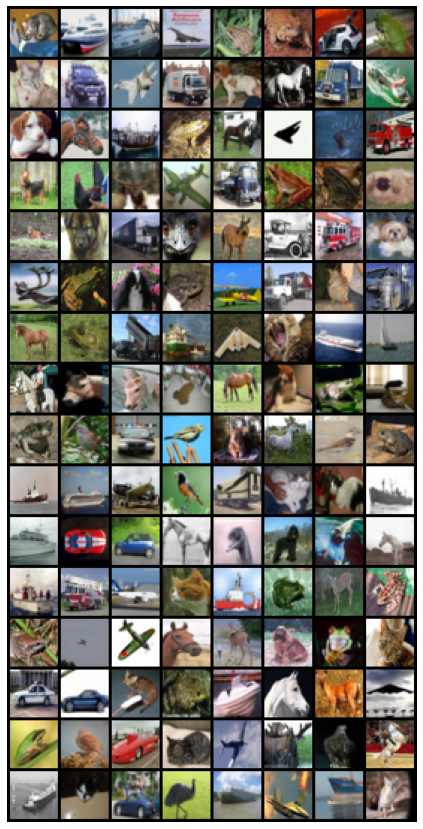

In [5]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

#### Model Definition
Define hyperparameters and the model

In [6]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.

num_epochs = 20
learning_rate = 0.0002
learning_rate_G = 0.0002
learning_rate_D = 0.0001
latent_vector_size = 150

# Other hyperparams
gen_fm = 150
disc_fm = 64

In [7]:
# *CODE FOR PART 2.1 IN THIS CELL*


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.conv = nn.Sequential(
            # Use fully connected layers to map the low-dimensional latent space to higher-dimensional representations.
            nn.ConvTranspose2d(latent_vector_size, gen_fm * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_fm * 8),
            nn.ReLU(True),
            # state size is (gen_fm * 8) x 4 x 4
            nn.ConvTranspose2d(gen_fm * 8, gen_fm * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_fm * 4),
            nn.ReLU(True),
            # state size is (gen_fm * 4) x 8 x 8
            nn.ConvTranspose2d(gen_fm * 4, gen_fm * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_fm * 2),
            nn.ReLU(True),
            # state size is (gen_fm * 2) x 16 x 16
            nn.ConvTranspose2d(gen_fm * 2, gen_fm, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_fm),
            nn.ReLU(True),
            # state size is gen_fm x 32 x 32
            nn.ConvTranspose2d(gen_fm, 3, 3, 1, 1, bias=False),
            nn.Tanh()

            # state size is 3 x 32 x 32
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.conv(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.conv = nn.Sequential(
            # input is 3 x 32 x 32
            nn.Conv2d(3, disc_fm, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size is disc_fm x 32 x 32
            nn.Conv2d(disc_fm, disc_fm * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_fm * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size is (disc_fim * 2) x 16 x 16
            nn.Conv2d(disc_fm * 2, disc_fm * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_fm * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size is (disc_fm * 4) x 8 x 8
            nn.Conv2d(disc_fm * 4, disc_fm * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_fm * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size is (disc_fm * 8) x 4 x 4

        )
        self.final_layer  = nn.Sequential(
            nn.Conv2d(disc_fm * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.conv(x)
        out = self.final_layer(out)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

        return out


<h2> Initialize Model and print number of parameters </h2>

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
def init_models():
    use_weights_init = True

    model_G = Generator().to(device)
    if use_weights_init:
        model_G.apply(weights_init)
    params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
    print("Total number of parameters in Generator is: {}".format(params_G))
    print(model_G)
    print('\n')

    model_D = Discriminator().to(device)
    if use_weights_init:
        model_D.apply(weights_init)
    params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
    print("Total number of parameters in Discriminator is: {}".format(params_D))
    print(model_D)
    print('\n')

    print("Total number of parameters is: {}".format(params_G + params_D))
    return model_G, model_D, params_G, params_D

### Part 2.1b: Training the Model (12 Points)

#### Defining a Loss

In [10]:
# You can modify the arguments of this function if needed
def G_loss_function(y, y_hat):
    loss = nn.BCELoss()
    return loss(y_hat, y)

# You can modify the arguments of this function if needed
def D_loss_function(y, y_hat):
    loss = nn.BCELoss()
    return loss(y_hat, y)

def loss_hist(params, params_avg):
    # using mean squared error root mean squared error as it was breaking the learning process (lead to NaNs)
    loss = F.mse_loss(params, params_avg)
    return loss

In [13]:
def calculate_gradient_penalty(model, real_images, fake_images, device):
    """Calculates the gradient penalty loss for WGAN GP

    For Wasserstein loss. But it didn't work.
    """
    # Random weight term for interpolation between real and fake data
    alpha = torch.randn((real_images.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty



<h3>Choose and initialize optimizers</h3>

In [14]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
model_G, model_D, _, _ = init_models()
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_D, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_G, betas=(beta1, 0.999))



Total number of parameters in Generator is: 18008550
Generator(
  (conv): Sequential(
    (0): ConvTranspose2d(150, 1200, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1200, 600, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(600, 300, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(300, 150, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(150, 3, kernel_size=(3, 3), stride=

<h3> Define fixed input vectors to monitor training and mode collapse. </h3>

In [13]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
# Additional input variables should be defined here
real_label = 0.9
fake_label = 0.1

#### Training Loop

Complete the training loop below. We've defined some variables to keep track of things during training:
* errD: Loss of Discriminator after being trained on real and fake instances
* errG: Loss of Generator
* D_x: Output of Discriminator for real images
* D_G_z1: Output of Discriminator for fake images (When Generator is not being trained)
* D_G_z2: Output of Discriminator for fake images (When Generator is being trained)

In [16]:
""" *** STANDARD GAN WITH NO HISTORICAL AVERAGING *** NB NOT USED IN FINAL REPORT"""

train_losses_G = []
train_losses_D = []

# <- You may wish to add logging info here
for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0

            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            # Train with real
            model_D.zero_grad()
            real_cpu = data[0].to(device)
            size = real_cpu.size(0)
            output_real = model_D(real_cpu).view(-1)
            target = torch.full((size,), real_label, dtype=torch.float, device=device)
            errD_real = D_loss_function(target, output_real)
            errD_real.backward()
            D_x = output_real.mean().item()

            # train with fake
            noise = torch.randn(size, latent_vector_size, 1, 1, device=device)
            fake_image = model_G(noise)
            target = target.fill_(fake_label)
            output_fake = model_D(fake_image.detach()).view(-1)

            # Update gradients
            errD_fake = D_loss_function(target, output_fake)
            errD_fake.backward()

            errD = errD_real + errD_fake
            D_G_z1 = output_fake.mean().item()
            train_loss_D += errD.item()

            optimizerD.step()

            # (2) Update G network: maximize log(D(G(z)))
            model_G.zero_grad()
            output = model_D(fake_image).view(-1)
            target = target.fill_(real_label)
            errG = G_loss_function(target, output)

            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()



            #######################################################################
            #                       ** END OF YOUR CODE **
            #######################################################################
            # Logging
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG.item())

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/new_lr_real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake.cpu()).float(), content_path/f'CW_GAN/new_lr_fake_samples_epoch{epoch}.png')
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

# save  models
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'CW_GAN/new_lr_GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'CW_GAN/new_lr_GAN_D_model.pth')

Epoch 19: 100%|██████████| 391/391 [01:41<00:00,  3.85batch/s, D_G_z=0.226/0.511, D_x=0.584, Loss_D=0.996, Loss_G=0.699]


Historical averaging:

In [11]:
model_G_hist, model_D_hist, params_G_hist, params_D_hist  = init_models()
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D_hist.parameters(), lr=learning_rate_D, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G_hist.parameters(), lr=learning_rate_G, betas=(beta1, 0.999))

Total number of parameters in Generator is: 18008550
Generator(
  (conv): Sequential(
    (0): ConvTranspose2d(150, 1200, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1200, 600, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(600, 300, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(300, 150, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(150, 3, kernel_size=(3, 3), stride=

In [15]:
""" *** STANDARD GAN WITH HISTORICAL AVERAGING *** NB USED IN FINAL REPORT"""

train_losses_G_hist = []
train_losses_D_hist = []
train_losses_G_all = []
train_losses_D_all = []

# <- You may wish to add logging info here
for epoch in range(50):
    # <- You may wish to add logging info here
    param_avg_G = torch.zeros(params_G_hist).to(device)
    param_avg_D = torch.zeros(params_D_hist).to(device)
    n = 0
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0

            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            # Train with real
            model_D_hist.zero_grad()
            real_cpu = data[0].to(device)
            size = real_cpu.size(0)
            output_real = model_D_hist(real_cpu).view(-1)
            target = torch.full((size,), real_label, dtype=torch.float, device=device)
            errD_real = D_loss_function(target, output_real)
            errD_real.backward()
            D_x = output_real.mean().item()

            # train with fake
            noise = torch.randn(size, latent_vector_size, 1, 1, device=device)
            fake_image = model_G_hist(noise)
            target = target.fill_(fake_label)
            output_fake = model_D_hist(fake_image.detach()).view(-1)

            # Update gradients
            errD_fake = D_loss_function(target, output_fake)
            errD_fake.backward()

            # *** HISTORICAL AVERAGING
                        # Get current parameters of D and calculate the running mean of D's parameters
            param_D_current = torch.cat([param.view(-1) for param in model_D_hist.parameters()]).to(device)
            param_avg_D = ( (n*param_avg_D.detach()  + param_D_current.detach()) / (n+1)).to(device)

            # Calculate historical average loss using the root mean square error (L2-norm)
            errD_hist_avg = loss_hist(param_D_current, param_avg_D)
            errD_hist_avg.backward()

            # Add the historical average loss to the total loss (as a penalty term for the regularization)
            errD = errD_real + errD_fake + errD_hist_avg

            D_G_z1 = output_fake.mean().item()
            train_loss_D += errD.item()

            optimizerD.step()

            # (2) Update G network: maximize log(D(G(z)))
            model_G_hist.zero_grad()
            output = model_D_hist(fake_image).view(-1)
            target = target.fill_(real_label)
            errG_standard = G_loss_function(target, output)
            errG_standard.backward()
            D_G_z2 = output.mean().item()

            param_G_current = torch.cat([param.view(-1) for param in model_G_hist.parameters()]).to(device)
            param_avg_G = ((n * param_avg_G.detach() + param_G_current.detach())/ (n+1)).to(device)

            # Calculate historical average loss using the root mean square error (L2-norm)
            errG_avg = loss_hist(param_G_current, param_avg_G)
            errG_avg.backward()
            errG = errG_avg + errG_standard

            train_loss_G += errG.item()

            optimizerG.step()
            train_losses_D_all.append(errD.item())
            train_losses_G_all.append(errG.item())
            n += 1



            #######################################################################
            #                       ** END OF YOUR CODE **
            #######################################################################
            # Logging
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG.item())

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/historical_averaging/real_samples.png')
    with torch.no_grad():
        fake = model_G_hist(fixed_noise)
        save_image(denorm(fake.cpu()).float(), content_path/f'CW_GAN/historical_averaging/fake_samples_epoch{epoch}.png')
    train_losses_D_hist.append(train_loss_D)
    train_losses_G_hist.append(train_loss_G)

# save  models
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(torch.jit.trace(model_G_hist, (fixed_noise)), content_path/'CW_GAN/historical_averaging/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D_hist, (fake)), content_path/'CW_GAN/historical_averaging/GAN_D_model.pth')


Epoch 49: 100%|██████████| 391/391 [01:54<00:00,  3.43batch/s, D_G_z=0.175/0.207, D_x=0.798, Loss_D=0.742, Loss_G=1.52]


Wasserstein GAN

In [19]:
model_G_was, model_D_was, params_G_was, params_D_was  = init_models()
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D_was.parameters(), lr=learning_rate_D, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G_was.parameters(), lr=learning_rate_G, betas=(beta1, 0.999))


Total number of parameters in Generator is: 18008550
Generator(
  (conv): Sequential(
    (0): ConvTranspose2d(150, 1200, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1200, 600, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(600, 300, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(300, 150, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(150, 3, kernel_size=(3, 3), stride=

In [20]:
""" *** WASSERSTEIN LOSS no HISORICAL AVERAGING *** """
train_losses_G_was = []
train_losses_D_was = []

# <- You may wish to add logging info here
for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    param_avg_G = torch.zeros(params_G_was).to(device)
    param_avg_D = torch.zeros(params_D_was).to(device)
    n = 0
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0

            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            # Train with real
            model_D_was.zero_grad()
            real_cpu = data[0].to(device)
            output_real = model_D_was(real_cpu).view(-1)
            D_x = output_real.mean().item()
            errD_real = torch.mean(output_real)
            size = data[0].size(0)

            noise = torch.randn(size, latent_vector_size, 1, 1, device=device)
            fake_image = model_G_was(noise)


            # train with fake
            output_fake = model_D_was(fake_image.detach()).view(-1)
            errD_fake = torch.mean(output_fake)
            D_G_z1 = output_fake.mean().item()


            # Update gradients
            gradient_penalty = calculate_gradient_penalty(model_D_was, real_cpu.data, fake_image.data, device)
            errD = -errD_real + errD_fake + gradient_penalty * 10
            errD.backward()
            # Add the historical average loss to the total loss (as a penalty term for the regularization)
            optimizerD.step()

            # (2) Update G network: maximize log(D(G(z)))
            model_G_was.zero_grad()
            fake_image = model_G_was(noise)
            output = model_D_was(fake_image).view(-1)
            errG = -torch.mean(output)
            D_G_z2 = output.mean().item()
            # Calculate historical average loss using the root mean square error (L2-norm)
            errG.backward()
            optimizerG.step()




            #######################################################################
            #                       ** END OF YOUR CODE **
            #######################################################################
            # Logging
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG.item())

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/wasserstein_loss/new_lr_real_samples.png')
    with torch.no_grad():
        fake = model_G_was(fixed_noise)
        save_image(denorm(fake.cpu()).float(), content_path/f'CW_GAN/wasserstein_loss/new_lr_fake_samples_epoch{epoch}.png')
    train_losses_D_was.append(train_loss_D / len(loader_train))
    train_losses_G_was.append(train_loss_G / len(loader_train))

# save  models
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(torch.jit.trace(model_G_was, (fixed_noise)), content_path/'CW_GAN/wasserstein_loss/new_lr_GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D_was, (fake)), content_path/'CW_GAN/wasserstein_loss/new_lr_GAN_D_model.pth')


Epoch 19: 100%|██████████| 391/391 [02:44<00:00,  2.38batch/s, D_G_z=1.000/1.000, D_x=0.938, Loss_D=2.51, Loss_G=-1]  


## Part 2.1c: Results (10 Points)
This part is fairly open-ended, but not worth too much so do not go crazy. The table below shows examples of what are considered good samples. Level 3 and above will get you 10/10 points, level 2 will roughly get you 5/10 points and level 1 and below will get you 0/10 points.

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="https://drive.google.com/uc?id=1wQ2f10-A1Vs7k0LMfBPPyYTsPlkBF9QE" width="%30">
    <br>
    <em style="color: grey">Level 1</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1wlDhX4hROET4s8Ndxn8nhj_0RLM2rnuG" width="%30">
    <br>
    <em style="color: grey">Level 2</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1w9VrgfJLCRaTPhwoFVYdYhtCeaQmFHGb" width="%30">
    <br>
    <em style="color: grey">Level 3</em>
  </p> 
</td>
</tr></table>

### Generator samples

/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


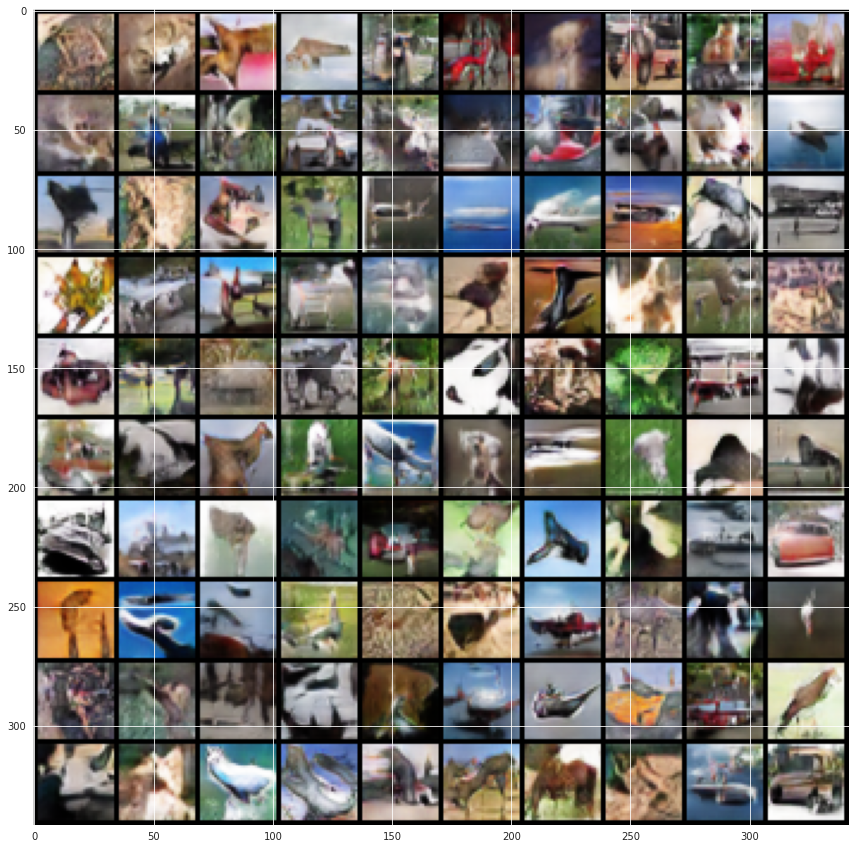

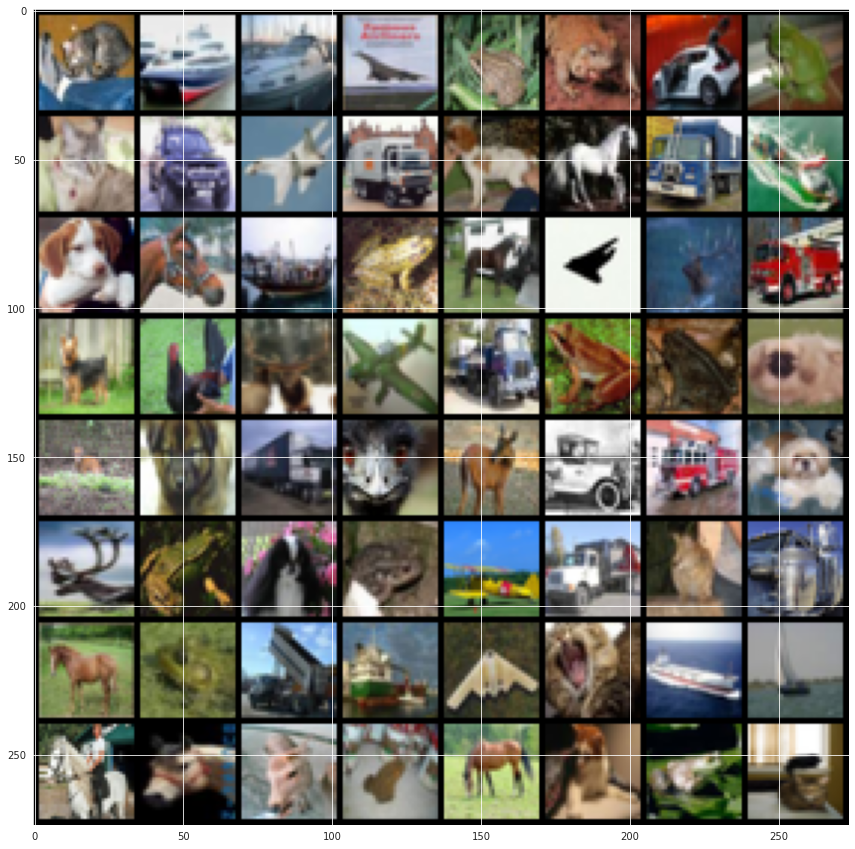

In [16]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G_hist(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

## Part 2.1d: Engineering Choices (10 Points)

Discuss the process you took to arrive at your final architecture. This should include:

* Which empirically useful methods did you utilize
* What didn't work, what worked and what mattered most
* Are there any tricks you came across in the literature etc. which you suspect would be helpful here

**Your Answer**

Given its success at recreating images, the initial step was to implement the DCGAN outlined by the DCGAN paper. All architectures experimented with were variations on the DCGAN. 

**Generator architecture**

The generator contained 5 convolutional layers. The following blocks were used for the first four layers:

- ConvTranspose2d - this is used to upsample the images from their latent vector size to the output size. The reason this is used over other upsampling methods is that it is learnable and optimised through backpropagation. It also learns to preserve and amplify the spatial structure of the input feature maps, while also generating new features at the up-sampled resolution. In contrast, other upsampling methods like nearest-neighbor and bilinear interpolation can produce blurry or low-resolution results, especially when used to upsample images with complex or fine-grained details.

- BatchNorm2d - used to stabilise and acccelarate the learning process. Batch norm normalises the activations of each layer which reduces the internal covariate shift of the inputs during training. The inputs therefore have a consistent distribution, making it easier to learn.

- ReLU - our output is pixel values, and we want these to be positive. Therefore using ReLU ensures that the output domain is correct. LeakyReLU was tried, but it had worse performance/did not learn.

For the final layer, a ConvTranspose2d block is followed by a Tanh activation. Tanh activation is used to normalise the output to 1. 

**Discriminator architecture**

The discriminator contained 5 convolutional layers. The first four layers used the following blocks:

- Conv2d - used to downsample the images from their initial size. Similarly to ConvTranspose2d, all parameters in a convolutional layer are learnable and therefore preferred to other downsampling methods. Conv2d layers can learn a set of filters that detect different features, such as edges, textures, and patterns, and can combine them to form more complex representations of the input images.

- BatchNorm2d - as above.

- LeakyReLU - leaky ReLU was preferred over ReLU for the discriminator as this mitigated the issues of vanishing gradients. 

**Network size**

- A variety of network sizes were experimented with, ranging from ~1 million parameters to ~20 million.

- It was found that a ratio of ~10:1 was suitable for the generator : discriminator parameter ratio. The moment for this is two fold:
    - A discriminator is easier to train, as the task of discriminating whether an image is real or fake is easier than generating a real-looking fake image.
    - We do not want the discriminator to be overpowered. This would cause the generator to not get any signal as to whether it is learning well as the discriminator would always be able to discriminate correctly.

- It was found that generally, larger networks performed better. Therefore the number of channels per convolutional layer was increased to give the generator ~20 million parameters and the discriminator ~2.5 million.

**Hyperparameters**

- By far the most important hyperparameter to tune was the learning rate of each model.
    - In the end two different learning rates were applied, with the discriminator having a learning rate half that of the generator.

- Number of epochs - this was kept relatively low (20) to speed up training time. The final model was retrained on 50 epochs.

- Batch size - this was kept to 128 to avoid memory issues.

- Latent vector size - A larger latent vector size can provide more information and expressiveness to the generator, allowing it to generate more diverse and complex images. However, a larger latent vector size can also make the training process more difficult and slower, since the generator has to learn a more complex mapping function. Here, a latent vector size of 150 was chosen to balance these.


**Methods tried to improve performance**

- Smoothing labels - the real and fake labels were changed to 0.9 and 0.1, respectively. By smoothing the labels, we introduce some uncertainty and noise into the discriminator's training process, which can encourage it to be more tolerant and accepting of generated images that are close but not identical to the real ones. This can improve the stability and robustness of the GAN, and prevent overfitting. The GAN was not learning using labels of 1 and 0, so this had a very large effect.

- Data normalisation: this was changed to have a mean and standard deviation of 0.5. This was because the produced images were faded and sub-optimal, so adjusting the pixel values to this produced better outputs.

- Historical averaging: Historical averaging involves maintaining a running average of the model parameters over the course of training, instead of using the current parameters directly. The running average is updated at each iteration by combining the current parameters with the previous average. It helps by reducing the impact of irrelevant or noisy updates to the generator. In other words, it prevents the generator on focusing too much on one specific feature that will fool the discriminator and instead makes it generalise more. This improved the output images, so was kept in the final model. 

- Wasserstein loss: Unlike traditional loss functions such as binary cross-entropy, Wasserstein loss measures the distance between the distribution of the generated samples and the real samples, allowing the generator to focus on generating samples that are more similar to the real data. It is used to prevent mode collapse. In this case, Wasserstein loss had a detrimental effect to training, so was omitted in the final model.

**Other tricks that would be helpful**

- Feature matching: this means extracting high-level features from the intermediate layers of the discriminator network and using them as a feedback signal to guide the generator's training. This would be the first thing I would do if I did this project again, however due to time constraints this was not implemented. 

## Part 2.2: Understanding GAN Training (5 points)


### Loss Curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

Make sure that the version of the notebook you deliver includes these results.

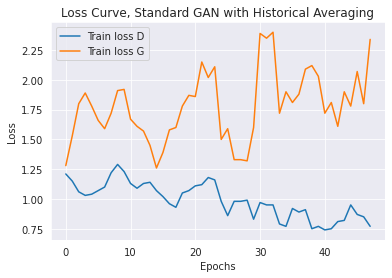

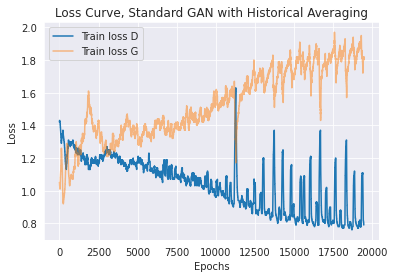

In [30]:
# ANSWER FOR PART 2.2 IN THIS CELL*
import json
import scipy as sp
# ANSWER FOR PART 2.2 IN THIS CELL*

def moving_avg(arr, window_size=3):

    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []

    # Loop through the array t o
    #consider every window of size 3
    while i < len(arr) - window_size + 1:

        # Calculate the average of current window
        window_average = round(np.sum(arr[
          i:i+window_size]) / window_size, 2)

        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)

        # Shift window to right by one position
        i += 1

    return moving_averages

def plot_losses(loss_d, loss_g, title, alpha=1, window_size=3):
    g = moving_avg(loss_g, window_size=window_size)
    d = moving_avg(loss_d, window_size=window_size)
    plt.plot(d, label='Train loss D')

    plt.plot(g, label='Train loss G', alpha=alpha)

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()
    plt.close()

# print(len(train_losses_D))
# plot_losses(train_losses_D, train_losses_G, title='Loss Curve, Standard GAN')
# plot_losses(train_losses_D_was, train_losses_G_was, title='Loss Curve, Standard GAN with Wasserstein Loss')
plot_losses(train_losses_D_hist, train_losses_G_hist, 'Loss Curve, Standard GAN with Historical Averaging')
plot_losses(train_losses_D_all, train_losses_G_all, 'Loss Curve, Standard GAN with Historical Averaging', alpha=0.5, window_size=100)
a = {'train' : train_losses_D_hist,
     'traing' : train_losses_G_hist,
     'train_all' : train_losses_D_all,
     'train_allg' : train_losses_G_all}
with open('results.json', 'w') as file:
    json.dump(a, file)


### Discussion

Do your loss curves look sensible? What would you expect to see and why?

**YOUR ANSWER**

We expect to see two main features: first, both the generator and discriminator losses will oscillate. We can think of the losses as almost a zero sum game - as the discriminator gets better the generator loss will increase. This will cause the generator to learn a new feature that can trick the discriminator and therefore the generator loss will decrease with the discriminator loss increasing. This is the micro-scale behaviour we would expect to see. 

In the longer term, we would like to see the generator loss trending downwards whilst the discriminator loss increases. This is because we care about the quality of the generator, and not the discriminator as an output. Therefore with time we want the generator to 'win' the adversarial game and become more powerful than the discriminator, thus making the discriminator predict almost random values. This would cause the loss of the discriminator to be maximal, whilst the generator's to be minimal.

In these loss curves we see the initial trend is what we would like to see: the generator and discriminator are switching positions as they learn from each other The training also seems very noisy, which is the expected behaviour. However, it seems the discriminator is still over-powered compared to the generator as the loss for the generator increases as training continues rather than decreases. This implies the discriminator still finds it easy to discriminate despite the generator having learnt.

## Part 2.3: Understanding Mode Collapse (5 points) 
**Your task:**
 
Describe the what causes the phenomenon of Mode Collapse and how it may manifest in the samples from a GAN. 

Based on the images created by your generator using the `fixed_noise` vector during training, did you notice any mode collapse? what this behaviour may be attributed to, and what did you try to eliminate / reduce it?

In [23]:
# Any additional code

### Discussion


**YOUR ANSWER**

Mode collapse happens when the discriminator becomes too powerful, leading the generator to fair to produce sufficiently diverse and realistic samples to fool the discriminator. As a result, the generator may focus on generating samples that only cover a small subset of the target distribution, or even a single mode, leading to a limited and repetitive output. To address mode collapse, various techniques have been proposed, such as improving the diversity of the training data, modifying the loss function to encourage the generator to explore different modes, using regularization techniques such as dropout or weight decay, or incorporating additional feedback signals such as feature matching or mutual information. 

Mode collapse was seen on occasion when training the GAN. However, this was addressed using historical averaging to get the network to not focus too much on learning one specific feature that tricked the discriminator.



# TA Test Cell
TAs will run this cell to ensure that your results are reproducible, and that your models have been defined suitably. 

<font color="orange"> <b> Please provide the input and output transformations required to make your VAE and GANs work. If your GAN generator requires more than just noise as input, also specify this below (there are two marked cells for you to inspect) </b></font>


In [33]:
# If you want to run these tests yourself, change directory:
# %cd '.../dl_cw2/'
ta_data_path = "../data" # You can change this to = data_path when testing

In [34]:
!pip install -q torch torchvision

In [35]:
# Do not remove anything here
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt 

show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

# Do not change this cell!
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [43]:
############# CHANGE THESE (COPY AND PASTE FROM YOUR OWN CODE) #############
vae_transform = transforms.Compose([
    transforms.ToTensor(),
])

def vae_denorm(x):
    return x

mean = torch.Tensor([0.5, 0.5, 0.5])
std = torch.Tensor([0.5, 0.5, 0.5])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
def gan_denorm(x, channels=None, w=None ,h=None, resize = False):
    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

gan_latent_size = 150

# If your generator requires something other than noise as input, please specify
# two cells down from here

In [37]:
# Load VAE Dataset
test_dat = datasets.MNIST(ta_data_path, train=False, transform=vae_transform, 
                          download=True)
vae_loader_test = DataLoader(test_dat, batch_size=32, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [39]:
############# MODIFY IF NEEDED #############
vae_input, _ = next(iter(vae_loader_test))

# If your generator is conditional, then please modify this input suitably
input_noise = torch.randn(100, gan_latent_size, 1, 1, device=device)
gan_input = [input_noise] # In case you want to provide a tuple, we wrap ours

Used CNN


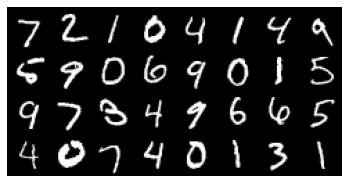

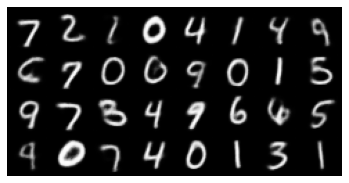

In [41]:
# VAE Tests
# TAs will change these paths as you will have provided the model files manually
"""To TAs, you should have been creating a folder with the student uid
   And the .ipynb + models in the root. Then that path is './VAE_model.pth' etc.
"""
vae = model_G = torch.jit.load('./CW_VAE/VAE_model.pth')
vae.eval()

# Check if VAE is convolutional
def recurse_cnn_check(parent, flag):
    if flag:
        return flag
    children = list(parent.children())
    if len(children) > 0:
        for child in children:
            flag = flag or recurse_cnn_check(child, flag)
    else:
        params = parent._parameters
        if 'weight' in params.keys():
            flag = params['weight'].ndim == 4
    return flag

has_cnn = recurse_cnn_check(vae, False)
print("Used CNN" if has_cnn else "Didn't Use CNN")

vae_in = make_grid(vae_denorm(vae_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_in)

vae_test = vae(vae_input.to(device))[0].detach()
vae_reco = make_grid(vae_denorm(vae_test), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_reco)

Number of Parameters is 20772774 which is ok


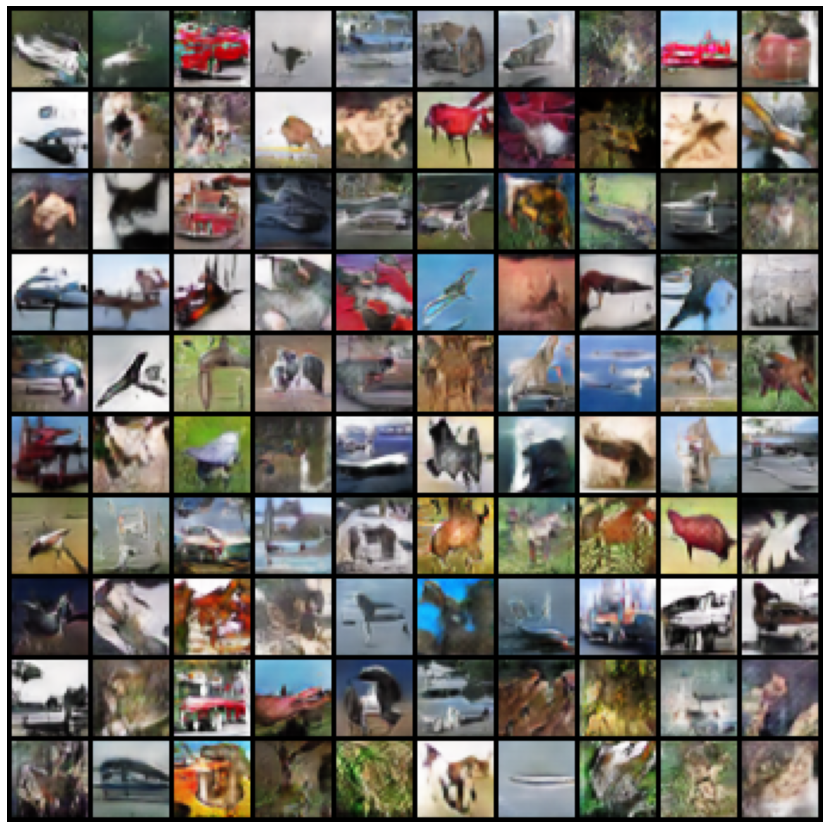

In [44]:
# GAN Tests
model_G = torch.jit.load('./CW_GAN/GAN_G_model.pth')
model_D = torch.jit.load('./CW_GAN/GAN_D_model.pth')
[model.eval() for model in (model_G, model_D)]  

# Check that GAN doesn't have too many parameters
num_param = sum(p.numel() for p in [*model_G.parameters(),*model_D.parameters()])

print(f"Number of Parameters is {num_param} which is", "ok" if num_param<25E+6 else "not ok")

# visualize the generated images
generated = model_G(*gan_input).cpu()
generated = make_grid(gan_denorm(generated)[:100].detach(), nrow=10, padding=2, normalize=False, 
                    range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
plt.axis('off')
show(generated)